<a href="https://colab.research.google.com/github/FreddieMG/BTD--Unsupervised-Detection-of-Medical-Deepfakes/blob/main/BTD_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
!pip install -q kaggle
!pip install denoising_diffusion_pytorch==1.8.3
clear_output()

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from IPython.display import clear_output, display
from PIL import Image
import matplotlib.pyplot as plt
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import random
from sklearn.utils import resample
from google.colab import files
from sklearn.metrics import roc_auc_score
from collections import OrderedDict
random.seed(0)

In [ ]:
# Load your kaggle token
files.upload()
clear_output()

In [ ]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d freddiegraboski/btd-mri-and-ct-deepfake-test-sets
! unzip "btd-mri-and-ct-deepfake-test-sets.zip"
clear_output()

## Datasets Initialization


In [ ]:

class MedicalDeepfakeDataset(Dataset):
    def __init__(self, root_dir, modality, attack_type, tamper_type, patch_size, transform=None):
        self.root_dir = root_dir
        self.modality = modality
        self.attack_type = attack_type
        self.tamper_type = tamper_type
        self.patch_size = patch_size
        self.half_size = patch_size//2

        self.transform = transform

        # Load the appropriate CSV file
        if modality == 'CT':
            csv_path = os.path.join(root_dir, f'CT/{attack_type}/CT_{attack_type}.csv')
            self.data_frame = pd.read_csv(csv_path)
            if tamper_type:
                self.data_frame = self.data_frame[self.data_frame[f'{tamper_type}-CT-{attack_type}'] == 1]
        elif modality == 'MRI':
            csv_path = os.path.join(root_dir, f'MRI/MRI_{attack_type}.csv')
            self.data_frame = pd.read_csv(csv_path)
        else:
            raise ValueError('Invalid modality. Choose either "CT" or "MRI".')

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.data_frame.iloc[idx]
        local_file_path = row['path']
        x, y = row[['x', 'y']].astype(int)
        label = row['type']
        scanner = row['scanner']

        # Load and normalize the image
        file_path = os.path.join(root_dir, local_file_path)
        if self.modality == 'CT':
            image = np.load(file_path)
            image = np.clip(image, -700, 2000)
            image = (image + 700) / 2700
            image = image.astype(np.float32)
            sample = torch.from_numpy(image).type(torch.FloatTensor)
        elif self.modality == 'MRI':
            image = Image.open(file_path)
            if self.transform:
                image = self.transform(image).squeeze().numpy()
                # some of the MRI slices are vertically flipped, we unflip them.
                if np.sum(image[-30:])<np.sum(image[:30]):
                    image = np.flip(image, axis=0).copy()
                    y = 512-y

        # Calculate patch coordinates
        if self.half_size - y > 0:
            y += self.half_size - y
        if self.half_size - x > 0:
            x += self.half_size - x
        if y + self.half_size > image.shape[0]:
            y -= abs(y + self.half_size - image.shape[0])
        if x + self.half_size > image.shape[1]:
            x -= abs(x + self.half_size - image.shape[1])

        # Extract patch
        patch = image[y - self.half_size: y + self.half_size, x - self.half_size: x + self.half_size].reshape(
            1, self.half_size * 2, self.half_size * 2)

        sample = {'image': patch, 'label': label, "scanner": scanner}

        return sample

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor()
])

# Define root directory
root_dir = ''

In [ ]:

# ## CTGAN-CT-Inject
# This dataset contains CT scans with cancer injected using the CTGAN method.
ctgan_ct_inject_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='CT',
    attack_type='injection',
    tamper_type='CTGAN',
    patch_size=96,
    transform=transform
)

# ## SD-CT-Inject
# This dataset contains CT scans with cancer injected using the Stable Diffusion method.
sd_ct_inject_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='CT',
    attack_type='injection',
    tamper_type='SD',
    patch_size=96,
    transform=transform
)

# ## CTGAN-CT-Remove
# This dataset contains CT scans with cancer removed using the CTGAN method.
ctgan_ct_remove_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='CT',
    attack_type='removal',
    tamper_type='CTGAN',
    patch_size=96,
    transform=transform
)

# ## SD-CT-Remove
# This dataset contains CT scans with cancer removed using the Stable Diffusion method.
sd_ct_remove_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='CT',
    attack_type='removal',
    tamper_type='SD',
    patch_size=96,
    transform=transform
)

# ## SD-MRI-Inject
# This dataset contains MRI scans with cancer injected using the Stable Diffusion method.
sd_mri_inject_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='MRI',
    attack_type='injection',
    tamper_type=None,  # No specific tamper type needed for MRI
    patch_size=128,
    transform=transform
)

# ## SD-MRI-Remove
# This dataset contains MRI scans with cancer removed using the Stable Diffusion method.
sd_mri_remove_dataset = MedicalDeepfakeDataset(
    root_dir=root_dir,
    modality='MRI',
    attack_type='removal',
    tamper_type=None,  # No specific tamper type needed for MRI
    patch_size=128,
    transform=transform
)


## Dataset Showcase

In [ ]:
def visualize_samples_from_datasets(datasets):
    for name, dataset in datasets.items():
        fig, axs = plt.subplots(2, 4, figsize=(16, 8))
        fig.suptitle(f'{name}', fontsize=18, fontweight='bold', y=1.02)

        dataset_length = len(dataset)
        quarter_length = dataset_length // 4

        # Select 4 random indices from the first half and 4 from the second half
        label_1_indices = random.sample(range(quarter_length), 4)
        label_2_indices = random.sample(range(quarter_length * 3, dataset_length), 4)

        # Determine the labels of the selected indices
        label1 = dataset[label_1_indices[0]]["label"]
        label2 = dataset[label_2_indices[0]]["label"]

        # Ensure that the label with "F" is placed on the left side
        if "F" in label1:
            fake_indices, true_indices = label_1_indices, label_2_indices
            fake_label, true_label = label1, label2
        else:
            fake_indices, true_indices = label_2_indices, label_1_indices
            fake_label, true_label = label2, label1

        # Plot fake images on the left side
        for j, idx in enumerate(fake_indices):
            sample = dataset[idx]
            ax = axs[j // 2, j % 2]  # Place in the left 2x2 grid
            ax.imshow(sample['image'].squeeze(), cmap='gray', aspect='auto')
            ax.axis('off')

        # Plot true images on the right side
        for j, idx in enumerate(true_indices):
            sample = dataset[idx]
            ax = axs[j // 2, (j % 2) + 2]  # Place in the right 2x2 grid
            ax.imshow(sample['image'].squeeze(), cmap='gray', aspect='auto')
            ax.axis('off')

        # Add centered labels above the respective grids
        fig.text(0.25, 0.92, fake_label, ha='center', fontsize=16, fontweight='bold')
        fig.text(0.75, 0.92, true_label, ha='center', fontsize=16, fontweight='bold')

        plt.tight_layout(rect=[0, 0.03, 1, 0.88])  # Adjust layout to fit the labels
        plt.show()

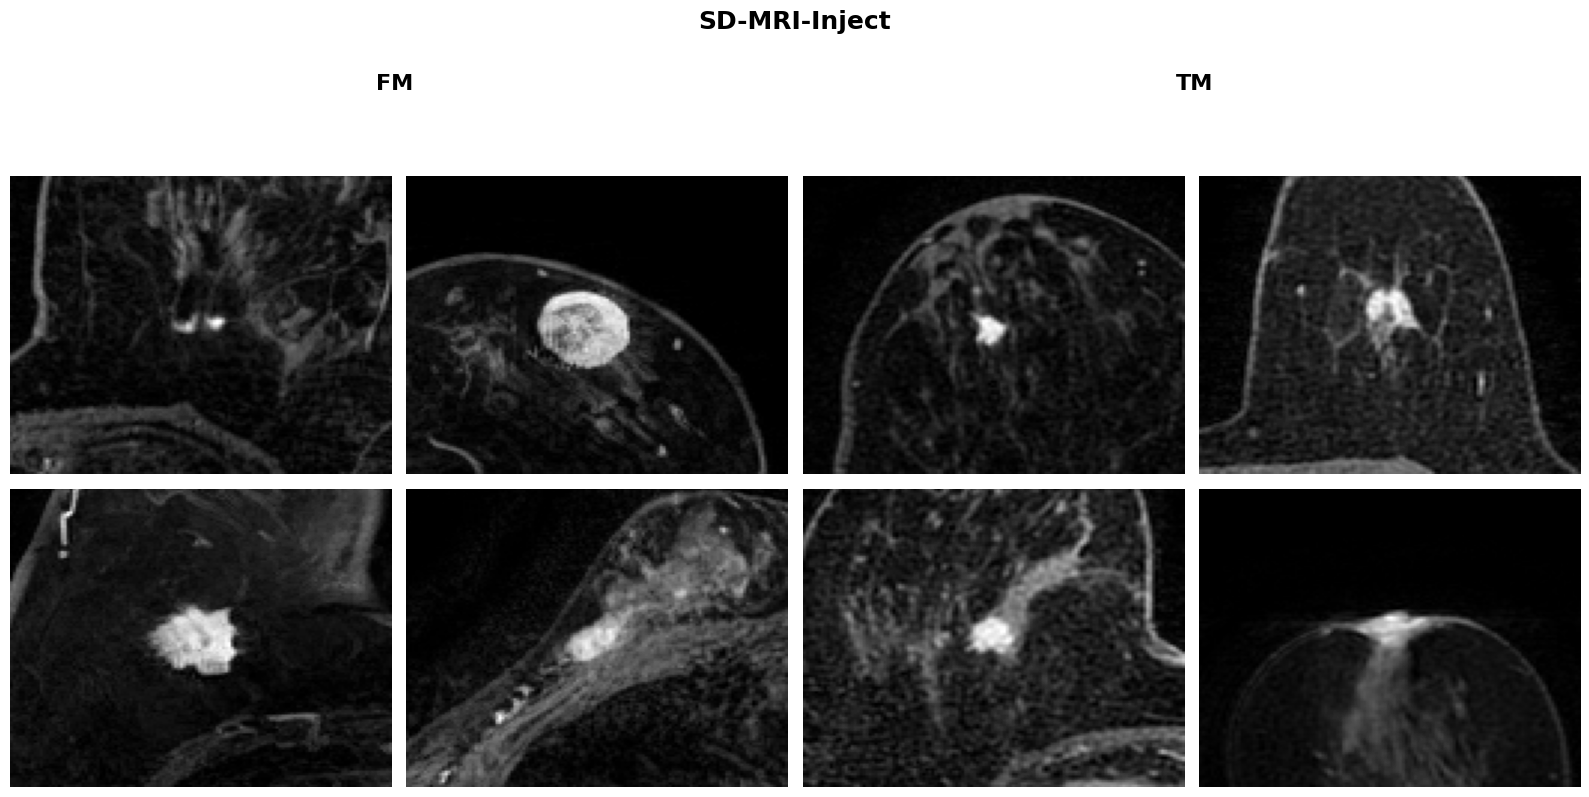

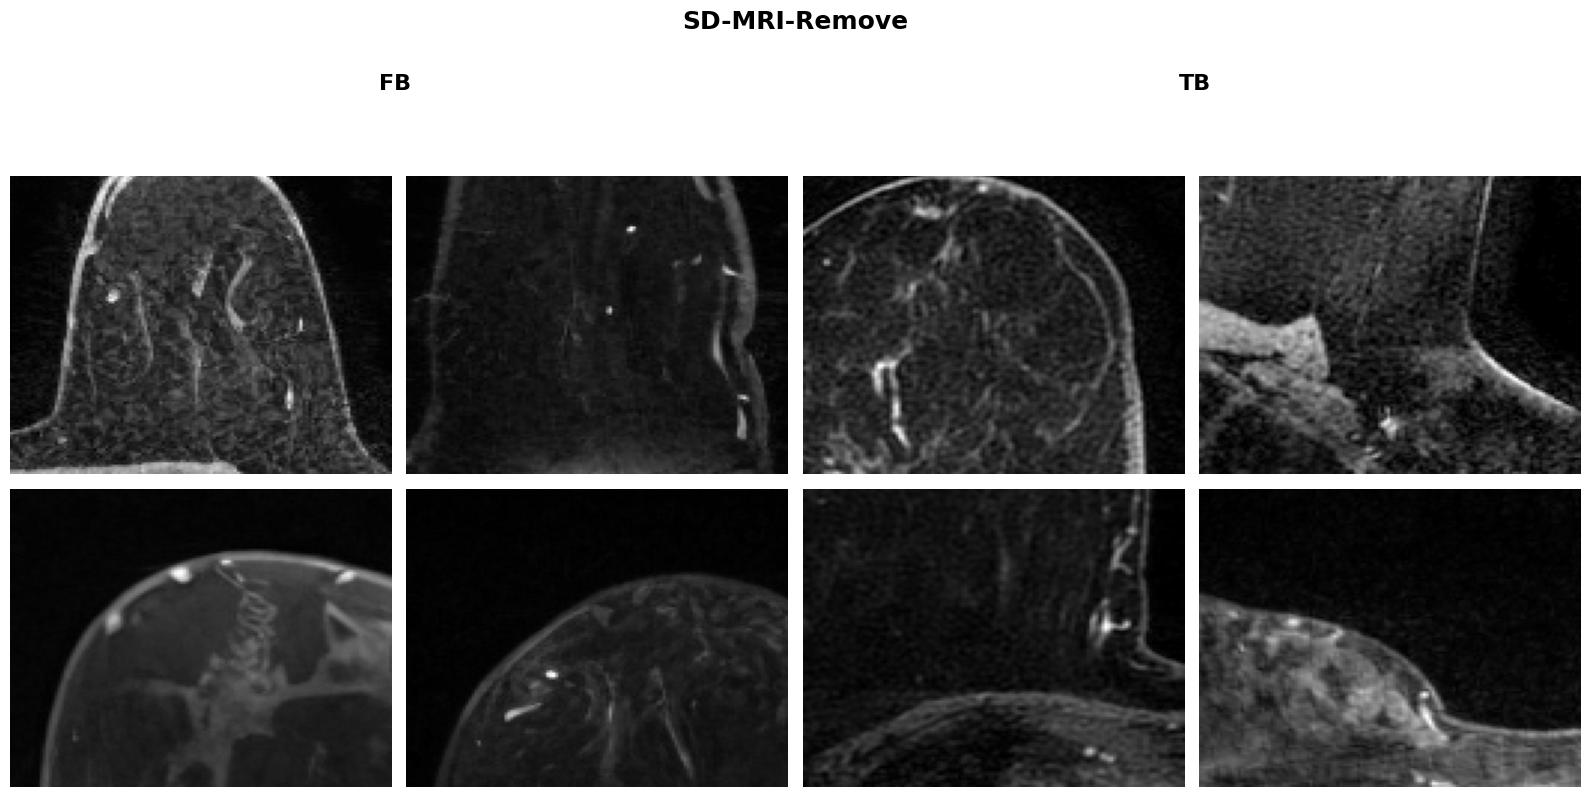

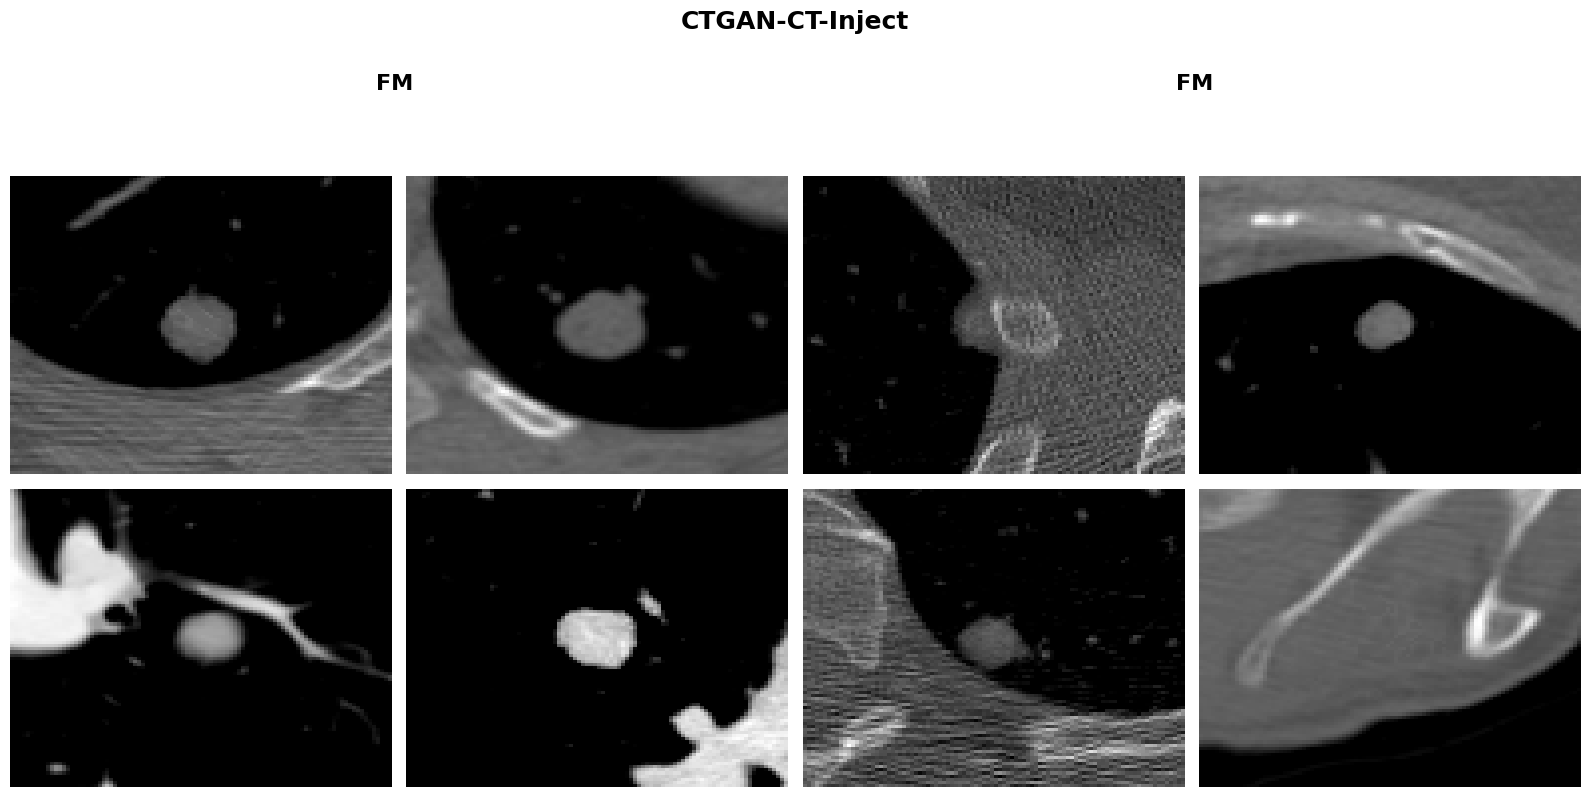

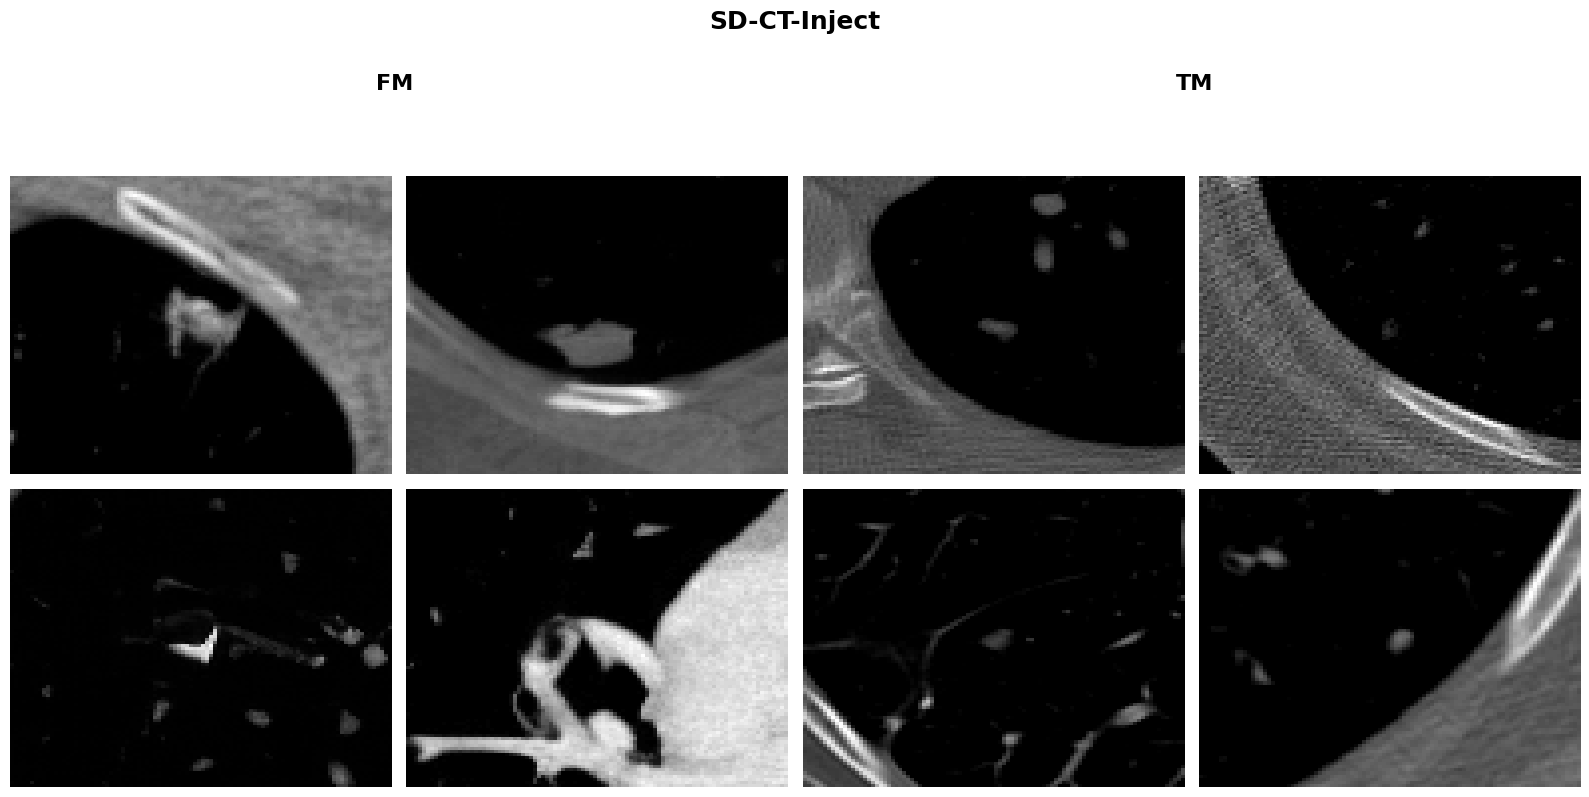

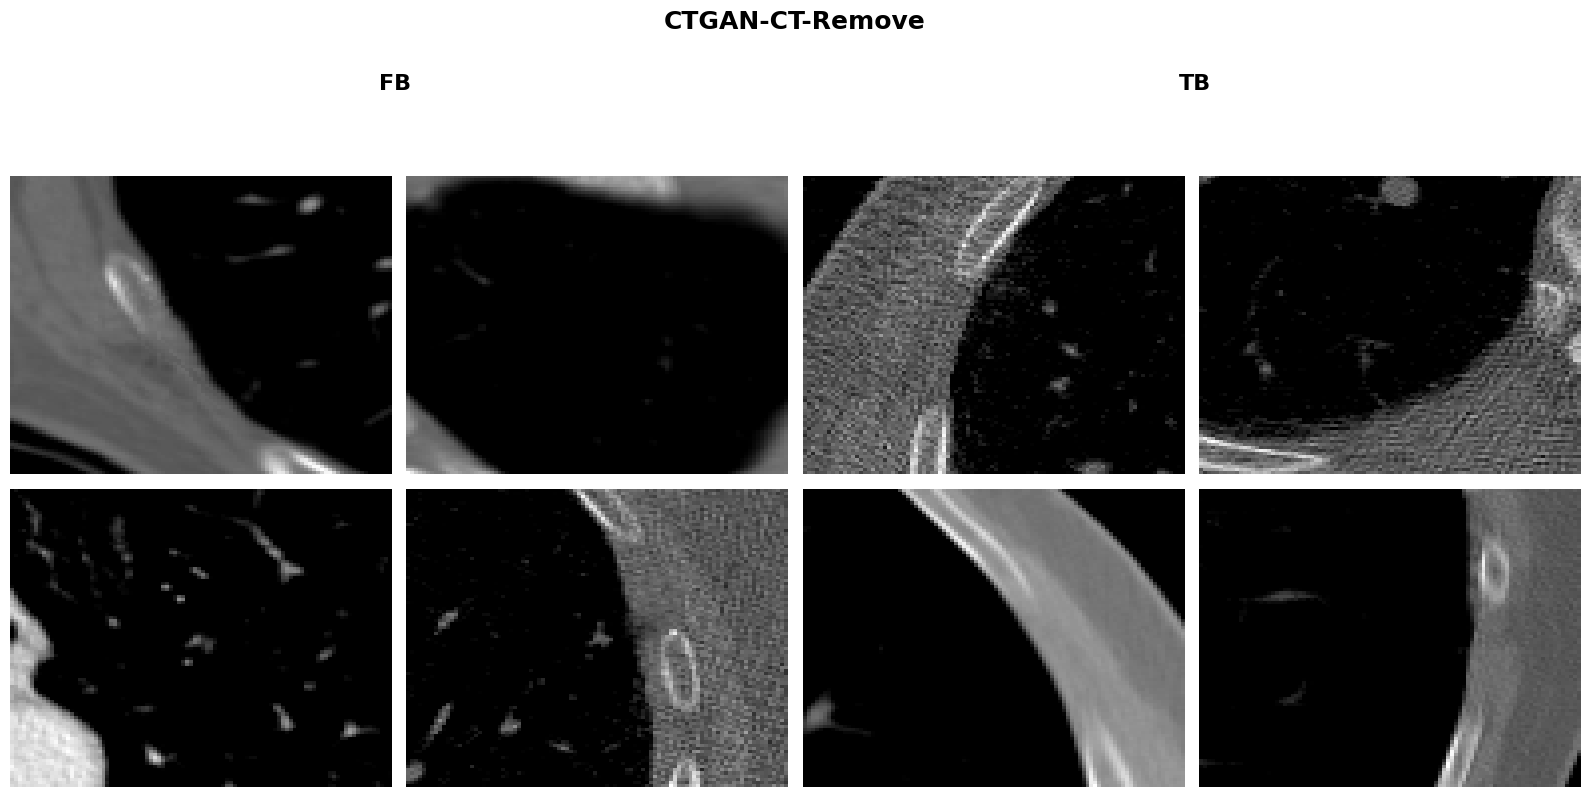

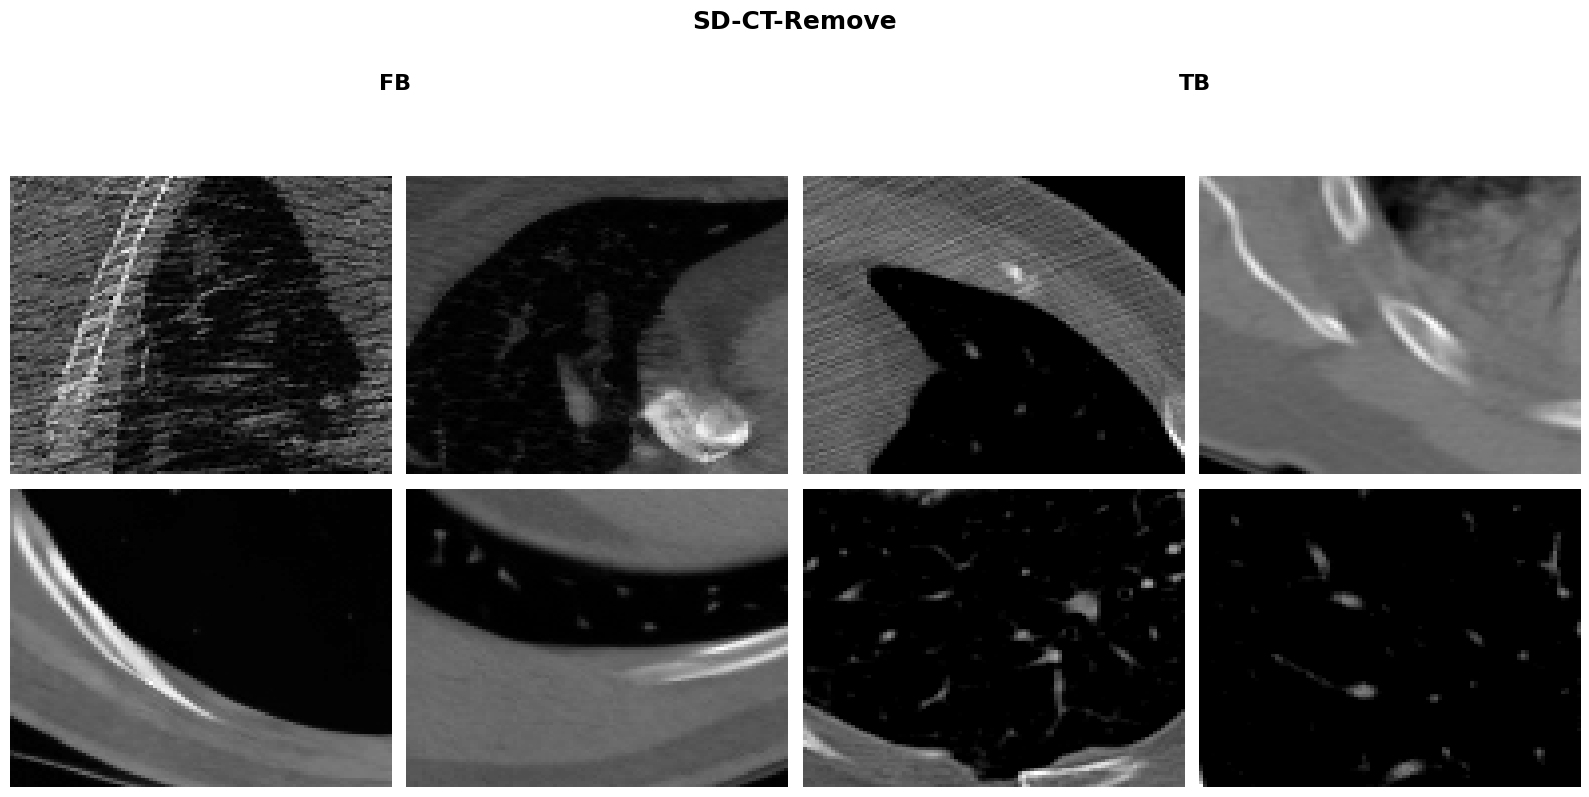

In [ ]:
# Create a dictionary of the datasets
datasets = {
    'SD-MRI-Inject': sd_mri_inject_dataset,
    'SD-MRI-Remove': sd_mri_remove_dataset,
    'CTGAN-CT-Inject': ctgan_ct_inject_dataset,
    'SD-CT-Inject': sd_ct_inject_dataset,
    'CTGAN-CT-Remove': ctgan_ct_remove_dataset,
    'SD-CT-Remove': sd_ct_remove_dataset
}

# Visualize the samples
visualize_samples_from_datasets(datasets)

## Loading Models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!wget https://github.com/FreddieMG/BTD--Unsupervised-Detection-of-Medical-Deepfakes/releases/download/v1.0-weights/CT_model.pt
!wget https://github.com/FreddieMG/BTD--Unsupervised-Detection-of-Medical-Deepfakes/releases/download/v1.0-weights/MRI_model.pt

clear_output()

In [ ]:

# Paths to the downloaded weights
CT_weights = 'CT_model.pt'
MRI_weights = 'MRI_model.pt'

# Initialize the UNet model
unet = Unet(
    dim = 32,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

# # Load the CT model
CT_model = GaussianDiffusion(
    unet,
    objective = "pred_noise",
    image_size = 96,
    timesteps = 1000,
    sampling_timesteps = 250
).to(device)

CT_model.load_state_dict(torch.load(CT_weights)['model'])
CT_model.eval()

unet = Unet(
    dim = 32,
    dim_mults = (1, 2, 4, 8),
    channels = 1
)

# Load the MRI model
MRI_model = GaussianDiffusion(
    unet,
    objective = "pred_noise",
    image_size = 128,
    timesteps = 1000,
    sampling_timesteps = 250
).to(device)

MRI_model.load_state_dict(torch.load(MRI_weights)['model'])
MRI_model.eval()

clear_output()

## Showcasing models

In [ ]:
def plot_timesteps_grid(images, timesteps, rows=3, cols=7):
    plt.figure(figsize=(20, 10))
    for i, (img, t) in enumerate(zip(images, timesteps)):
        plt.subplot(rows, cols, i + 1)
        to_save = img.cpu().numpy().squeeze()
        plt.imshow(to_save, cmap="bone")
        plt.title(f"Timestep {t}", fontsize=10)  # Increased font size
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.05)
    plt.suptitle("Reverse Diffusion Timesteps", fontsize=20)  # Increased main title font size
    plt.show()

### CT

Reverse Diffusion: 1000it [00:20, 49.08it/s]


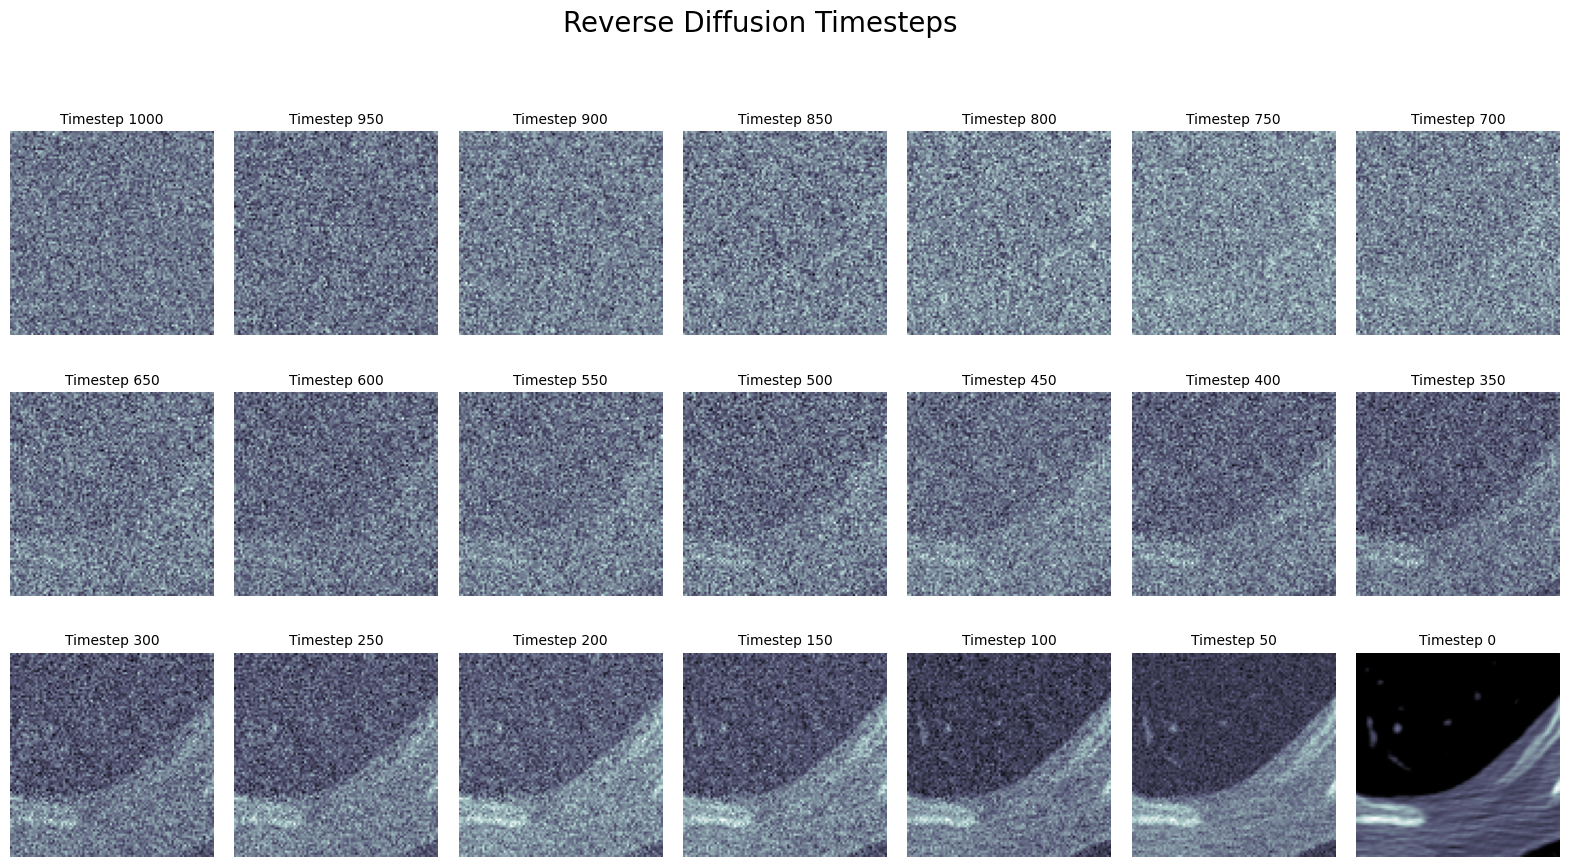

In [ ]:
img = torch.randn(torch.Size([1, 1, 96, 96]), device = device)

# List to store images and corresponding timesteps
images = []
timesteps = []

# Reverse diffusion process with elegant progress tracking
for t in tqdm(reversed(range(0, 1000)), desc="Reverse Diffusion", ncols=100):
    img, _ = CT_model.p_sample(img, t, None)

    # Save image at every 50th timestep
    if (t+1) % 50 == 0:
        images.append(img)
        timesteps.append(t+1)

images.append(img)
timesteps.append(t)

# Final plot of all collected timesteps in a 4x6 grid
plot_timesteps_grid(images, timesteps)

### MRI

Reverse Diffusion: 1000it [00:21, 46.24it/s]


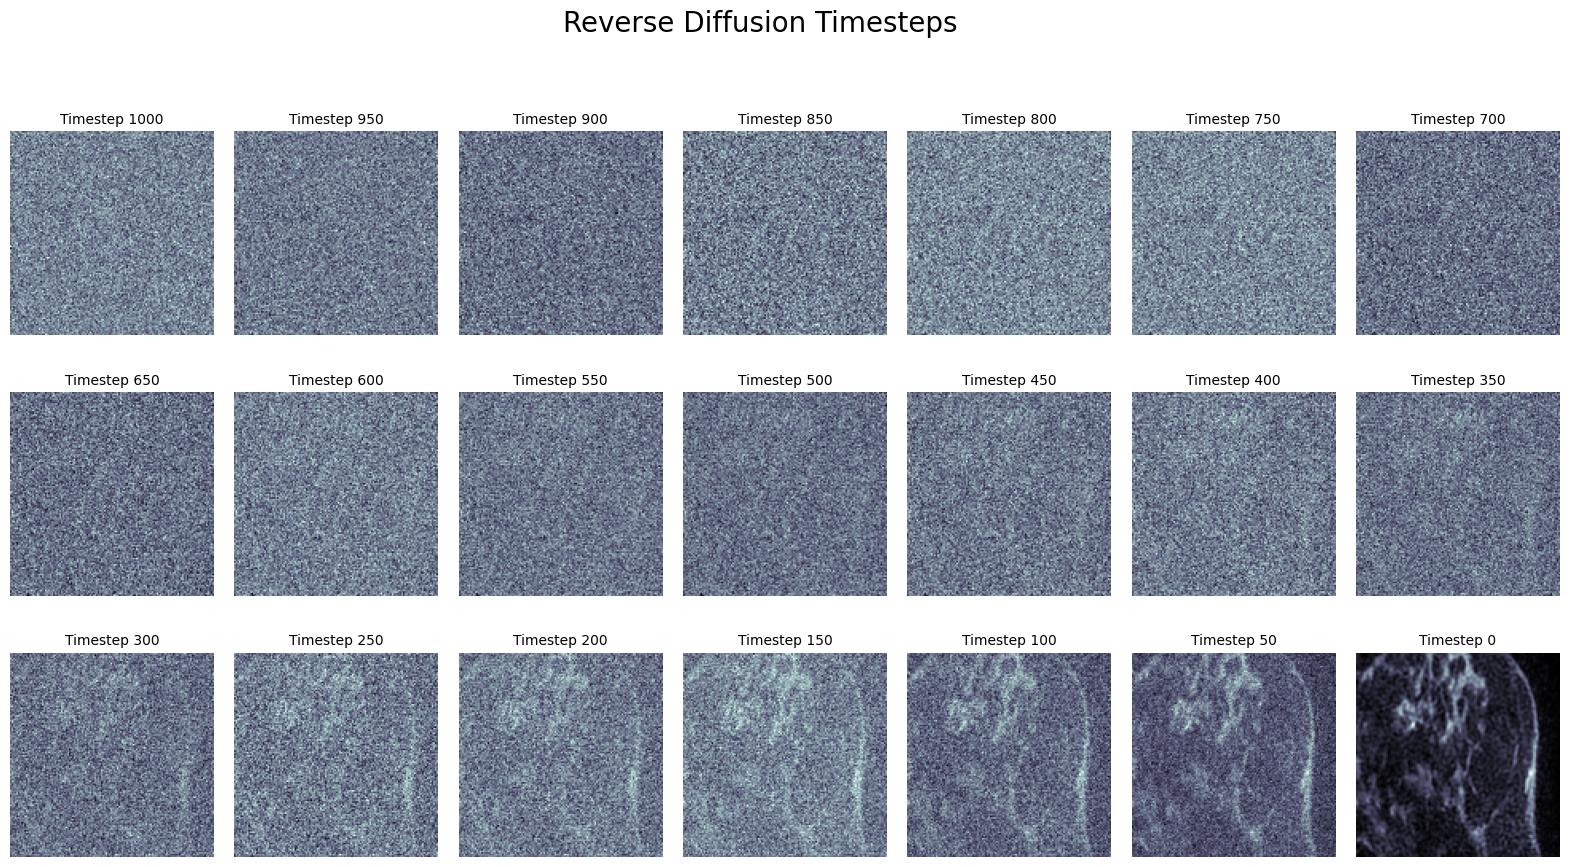

In [ ]:
img = torch.randn(torch.Size([1, 1, 128, 128]), device = device)

# List to store images and corresponding timesteps
images = []
timesteps = []

# Reverse diffusion process with elegant progress tracking
for t in tqdm(reversed(range(0, 1000)), desc="Reverse Diffusion", ncols=100):
    img, _ = MRI_model.p_sample(img, t, None)

    # Save image at every 50th timestep
    if (t+1) % 50 == 0:
        images.append(img)
        timesteps.append(t+1)

images.append(img)
timesteps.append(t)

# Final plot of all collected timesteps in a 4x6 grid
plot_timesteps_grid(images, timesteps)

## Evaluation

In [ ]:
@torch.no_grad()
def calculate_anomaly_scores(loader, diffusion, dataset_name, device):
    scanners = []
    score_array = []
    labels = []

    # Set the half size based on the dataset name
    half_size = 63 if dataset_name == "MRI" else 47
    focus = 16


    for data in loader:
        image, label, scanner = data["image"], data["label"], data["scanner"]

        labels.extend(label)
        scanners.extend(scanner)

        image = image.to(device)
        image = diffusion.normalize(image)

        # Generate the denoised image
        backed_batch, _ = diffusion.p_sample(image, 0, None)

        # If patch contains a tumpr, focus on that region
        if "Inject" in dataset_name:
            image = image[:, :, half_size-focus:half_size+focus, half_size-focus:half_size+focus]
            backed_batch = backed_batch[:, :, half_size-focus:half_size+focus, half_size-focus:half_size+focus]

        mse = F.mse_loss(image, backed_batch, reduction='none')  # Calculate MSE without reduction
        mse = mse.view(mse.size(0), -1).mean(dim=1)  # Average over all dimensions except batch
        score_array.extend(mse.cpu().numpy())  # Append the MSE scores for the entire batch


    baseline_scores = pd.DataFrame({'label': labels, 'scanner': scanners, "Anomaly Score": score_array})

    return baseline_scores

In [ ]:
def scanner_balanced_auc_calculation(data_type, baseline_scores):

    auc_scores = []
    scanner_list = list(baseline_scores.scanner.unique())

    if  "Inject" in data_type:
        T = "TM"
        F = "FM"
    else:
        T = "TB"
        F = "FB"
    min_count = np.inf

    for scanner in scanner_list:
            scanner_df = baseline_scores[baseline_scores['scanner']==scanner]
            scanner_tm = scanner_df[scanner_df['label']==T]
            scanner_fm = scanner_df[scanner_df['label']==F]
            min_count = min(min( len(scanner_tm), len(scanner_fm)), min_count)



    tm_data = baseline_scores[baseline_scores['label']==T]
    fm_data = baseline_scores[baseline_scores['label']==F]

    tm_datasets = {scanner: tm_data[tm_data['scanner']==scanner] for scanner in scanner_list}
    fm_datasets = {scanner: fm_data[fm_data['scanner']==scanner] for scanner in scanner_list}
    for i in range(100):
        cur_aucs = []
        balanced_data = pd.DataFrame()
        for scanner in scanner_list:

            df_tm_sampled = resample(tm_datasets[scanner], n_samples=min_count, replace=False, random_state=i)
            df_fm_sampled = resample(fm_datasets[scanner], n_samples=min_count, replace=False, random_state=i)
            balanced_data = pd.concat([balanced_data, df_tm_sampled, df_fm_sampled])

        y_true = np.where(balanced_data['label'] == T, 0, 1)  # Convert labels to binary
        y_pred = balanced_data["Anomaly Score"]
        auc = roc_auc_score(y_true, y_pred)
        auc_scores.append(auc)

    auc = np.mean(auc_scores)

    return auc

In [ ]:
# Initialize a dictionary to store results
datasets_scores = {"dataset": [], "AUC": []}

# Iterate through each dataset and calculate the AUC scores
for dataset_name, dataset in datasets.items():
    print(f"Evaluating {dataset_name}...")

    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Determine which model to use based on the dataset name
    model = CT_model if "CT" in dataset_name else MRI_model

    # Calculate anomaly scores using the appropriate model
    baseline_scores = calculate_anomaly_scores(dataloader, model, dataset_name, device)

    # Calculate the AUC score and store it in the dictionary
    auc = scanner_balanced_auc_calculation(dataset_name, baseline_scores)
    datasets_scores["dataset"].append(dataset_name)
    datasets_scores["AUC"].append(auc)

results = pd.DataFrame(datasets_scores)
display(results)


Evaluating SD-MRI-Inject...
Evaluating SD-MRI-Remove...
Evaluating CTGAN-CT-Inject...
Evaluating SD-CT-Inject...
Evaluating CTGAN-CT-Remove...
Evaluating SD-CT-Remove...


dataset       AUC
0    SD-MRI-Inject  0.988879
1    SD-MRI-Remove  0.979676
2  CTGAN-CT-Inject  0.807149
3     SD-CT-Inject  0.905844
4  CTGAN-CT-Remove  0.554574
5     SD-CT-Remove  0.859124